# Schedule TPC-DS 1 Feature Selection

This notebook is dedicated to dataset profiling. In this notebook, feature selection techniques will be implemented so as to categorize which features belay the most information to address the problem at hand - Workload Prediction. Due to the vast feature space which have been gathered during a workload's execution, manual techniques at determining which are most detrimental is not sufficient. 

Therefore the following work puts emphasis on automated techniques so as to determine out of the vast feature space which are most important to base future models upon. 

In [16]:
#
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2

In [17]:
tpcds='TPCDS1'
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
rep_hist_snapshot_headers = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_headers = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_headers = prettify_header(rep_hist_sysstat_df.columns.values)
rep_vsql_plan_headers = prettify_header(rep_vsql_plan_df.columns.values)
#
# Replace original headers with a prettified version of the same column list
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, names=rep_hist_snapshot_headers)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, names=rep_hist_sysmetric_summary_headers)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, names=rep_hist_sysstat_headers)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path, names=rep_vsql_plan_headers)
#
rep_hist_snapshot_df.drop(rep_hist_snapshot_df.index[0],inplace=True)
rep_hist_sysmetric_summary_df.drop(rep_hist_sysmetric_summary_df.index[0],inplace=True)
rep_hist_sysstat_df.drop(rep_hist_sysstat_df.index[0],inplace=True)
rep_vsql_plan_df.drop(rep_vsql_plan_df.index[0],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (26,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,4,5,7,8,9,10,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,77,78,79,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,3,5,6,7,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Program

# Dataset Description

The correlation of resources consumed (y) per snapshot (X) define our feature space. Since the objective here is to attempt to predict what resources will be incurred ahead of time, the problem can be defined as a number of questions:

* Q: What resources can I predict to be in usage at point N in time?
* Q: What resources should I be predicting that accurately portray a schedule's workload?
* Q: What knowledge/data do I have ahead of time which I can use to base my predictions off?

Due to the vast feature space in the available metrics monitored and captured during a workload's execution, it is important to rank which attribute is most beneficial than others. Additionally, it is important to analyze such features individually, and considerate of other features in two types of analysis:

* Univariate Analysis
* Multivariate Analysis

Furthermore, multiple types of feature ranking / analysis techniques ara available, amongst which will be considered:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Data Normalization

We apply a number of preprocessing techniques to the presented dataframes, particularly to normalize and/or scale feature vectors into a more suitable representation for downstream estimators:

Relative Links:
* http://scikit-learn.org/stable/modules/preprocessing.html
* https://machinelearningmastery.com/improve-model-accuracy-with-data-pre-processing/
* https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

## Visualizing Feature Distribution & Skewness

In order to decide between a normalization strategy, it is important to understand the underlying data spread. Understanding of dataset mean, variance, skewness on a per column/feature basis helps determine whether a standardization or normalization strategy should be utilized on the datasets.

### Normalization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

## Plotting Data Distribution

To better decide which normalization technique ought to be utilized for the technique at hand, a number of feature columns will be plotted as histograms to better convey the distribution spread.

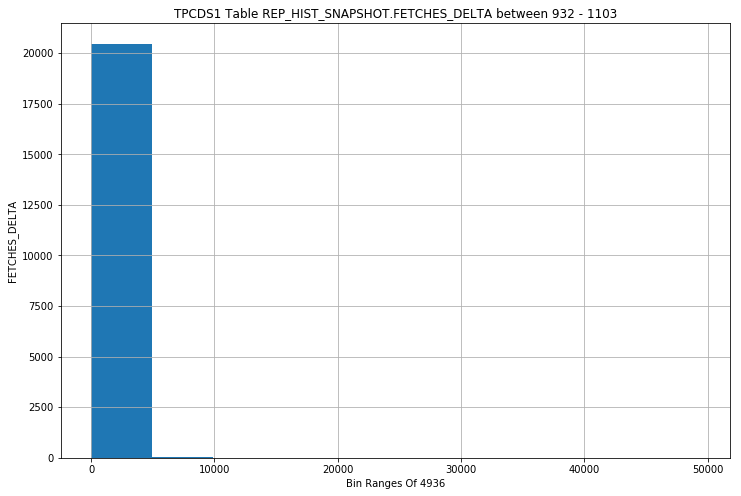

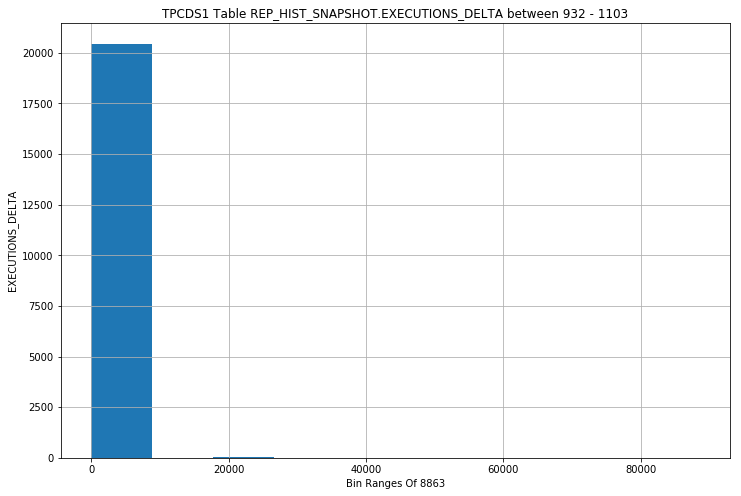

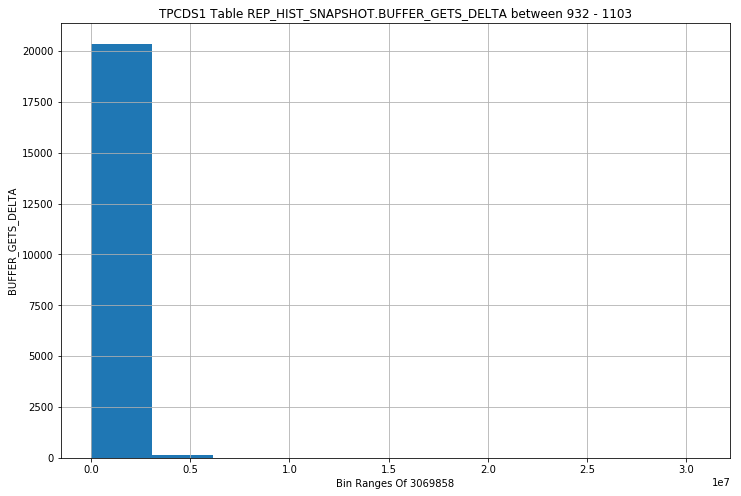

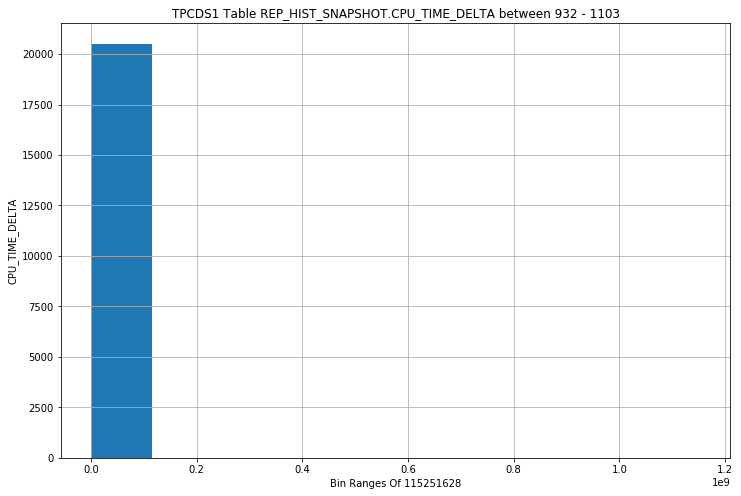

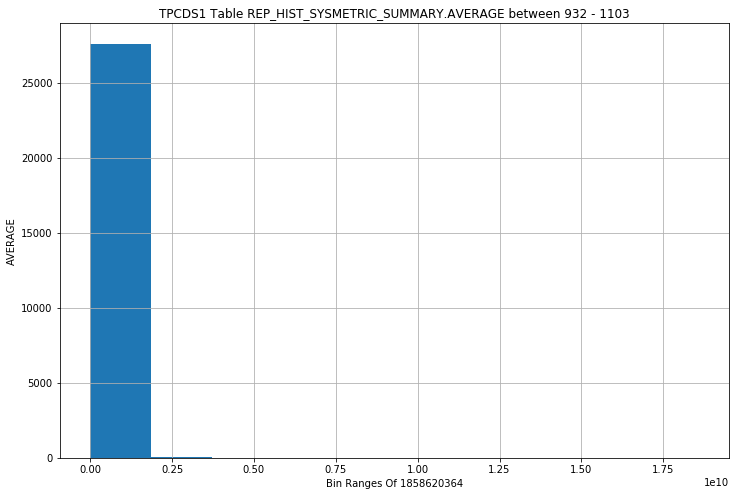

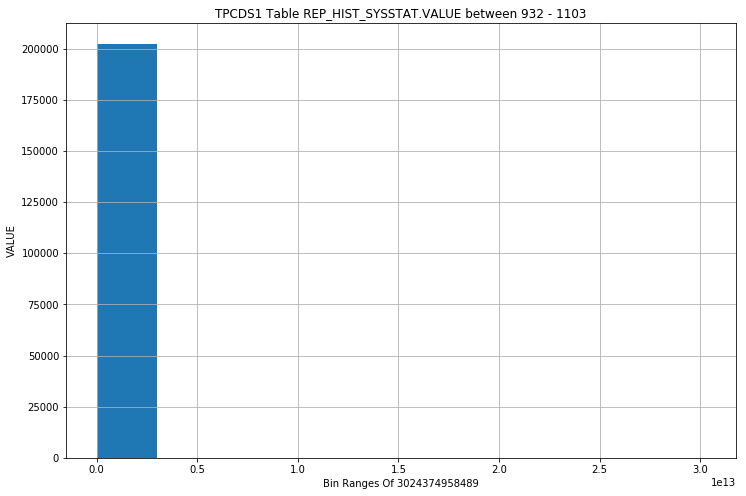

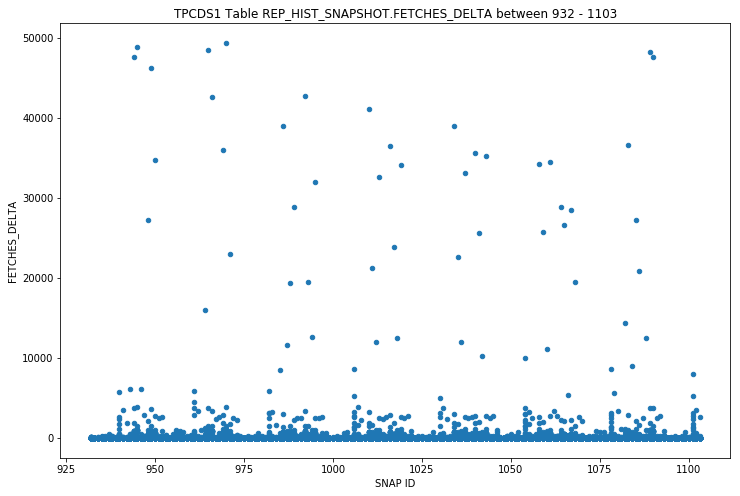

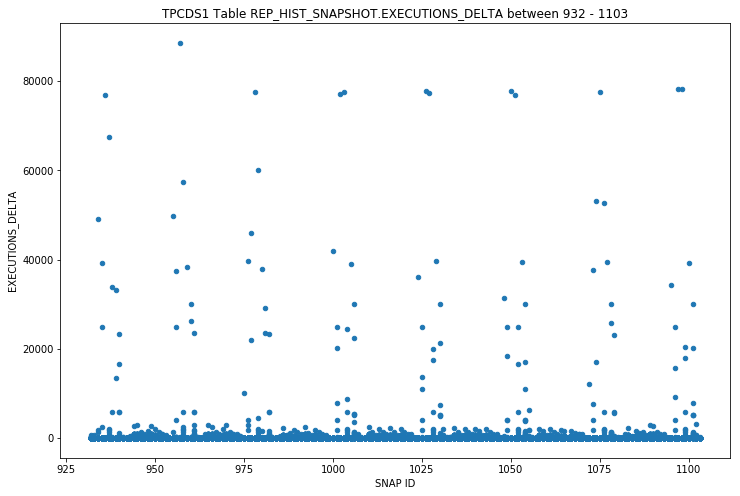

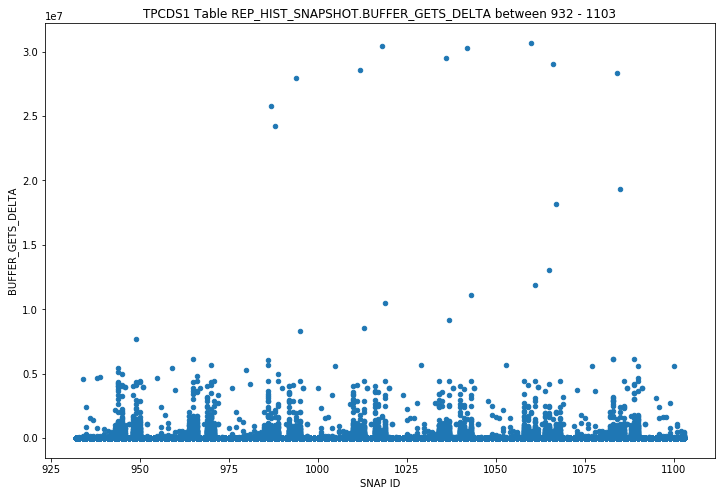

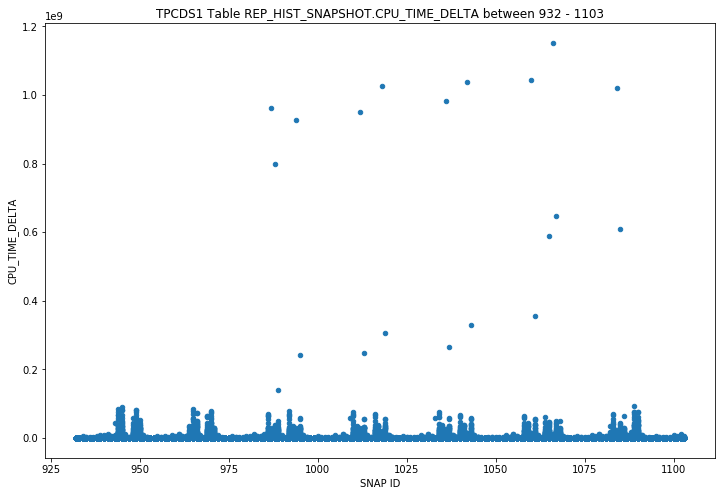

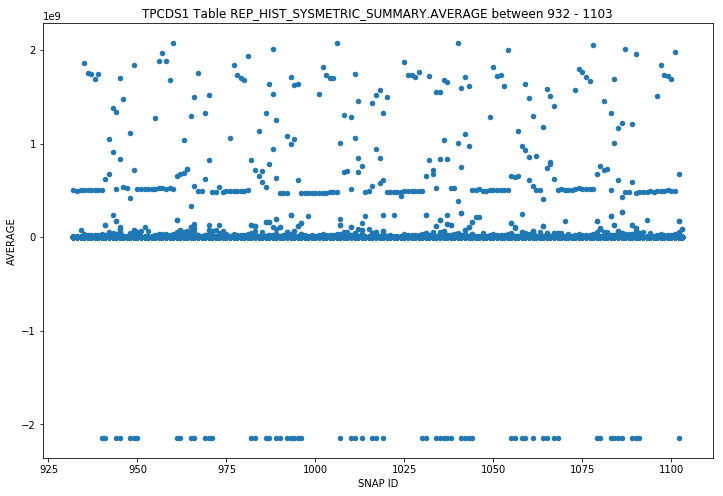

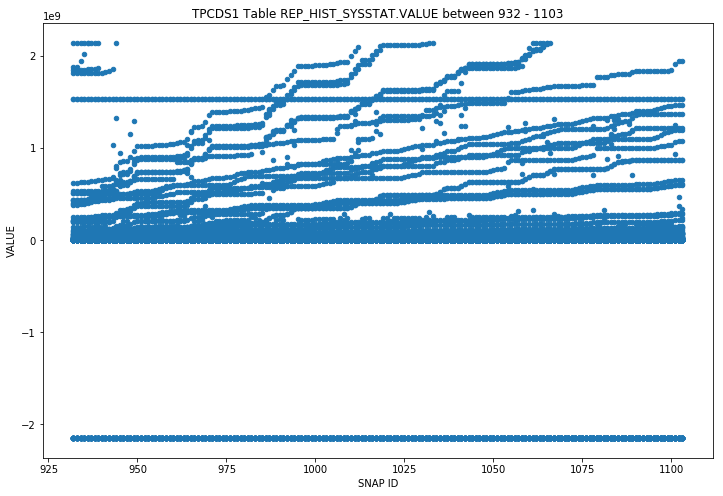

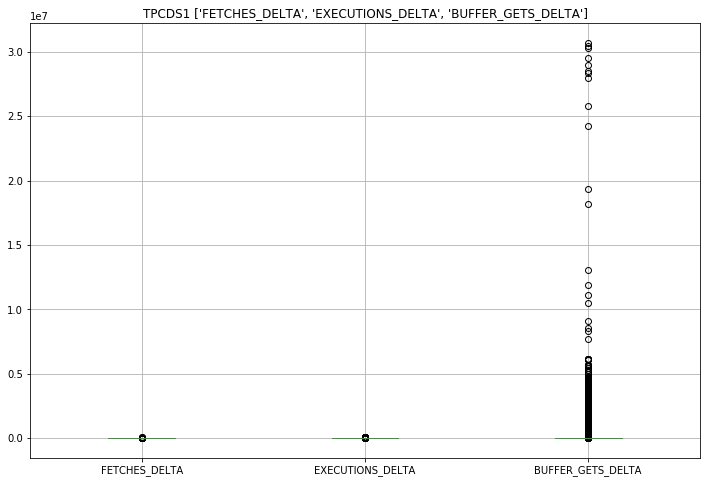

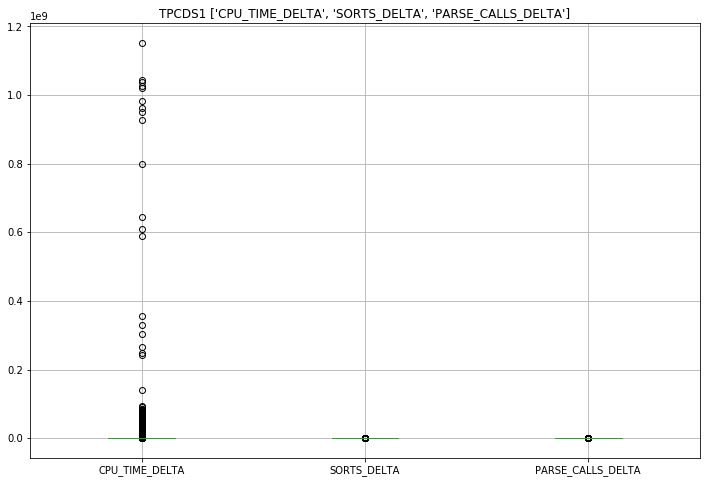

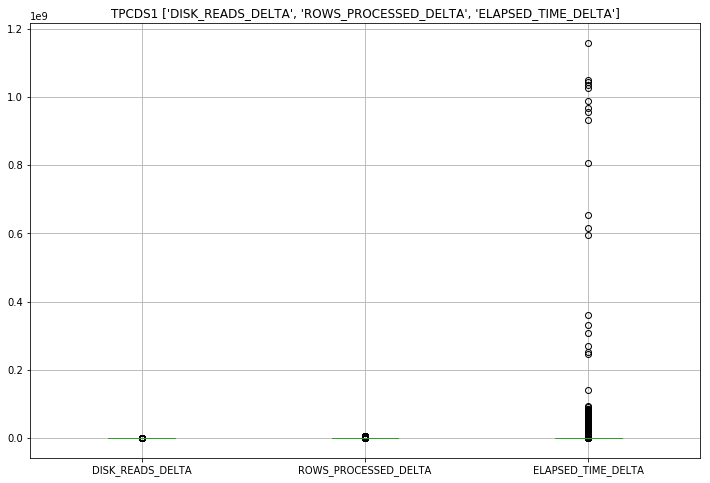

In [18]:
rep_hist_snapshot_headers = ['FETCHES_DELTA',
                             'EXECUTIONS_DELTA',
                             'BUFFER_GETS_DELTA',
                             'CPU_TIME_DELTA',
                             'SORTS_DELTA',
                             'PARSE_CALLS_DELTA',
                             'DISK_READS_DELTA',
                             'ROWS_PROCESSED_DELTA',
                             'ELAPSED_TIME_DELTA',
                             'IOWAIT_DELTA']
rep_hist_sysmetric_summary_headers = ['AVERAGE']
rep_hist_sysstat_headers = ['VALUE']
#
def plot_hist(df=None, tpc_type=None, table=None, feature_column=None, bin_size=10):
    """
    Plots histogram distribution
    """
    #
    df['SNAP_ID'] = df['SNAP_ID'].astype(float)
    df[feature_column] = df[feature_column].astype(float)
    #
    max_val = df[feature_column].max()
    start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
    #
    if table == 'rep_hist_snapshot':
        df[feature_column].hist(bins=10,figsize=(12,8))
    elif table == 'rep_hist_sysmetric_summary':
        df.groupby(['SNAP_ID','METRIC_ID'])[feature_column].sum().hist(bins=bin_size,figsize=(12,8))
    elif table == 'rep_hist_sysstat':
        df.groupby(['SNAP_ID','STAT_ID'])[feature_column].sum().hist(bins=bin_size,figsize=(12,8))
    plt.ylabel(feature_column)
    plt.xlabel('Bin Ranges Of ' + str(int(max_val/bin_size)))
    plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
    plt.show()
#
def plot_scatter(df=None, tpc_type=None, table=None, feature_column=None):
    """
    Plots scatter plots vs SNAP_ID
    """
    #
    df['SNAP_ID'] = df['SNAP_ID'].astype(int)
    df[feature_column] = df[feature_column].astype(int)
    start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
    #
    df.plot.scatter(x='SNAP_ID',
                    y=feature_column,
                    figsize=(12,8))
    plt.ylabel(feature_column)
    plt.xlabel('SNAP ID')
    plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
    plt.show()
#
def plot_boxplot(df=None, tpc_type=None, table=None, feature_columns=None):
    """
    Plots quartile plots to estimate mean and sigma (std dev)
    """
    #
    for feature_column in feature_columns:
        df[feature_column] = df[feature_column].astype(int)
    df.boxplot(column=feature_columns, figsize=(12,8), grid=True)
    plt.title(tpc_type + ' ' + str(feature_columns))
    plt.show()
#
plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='FETCHES_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='EXECUTIONS_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='BUFFER_GETS_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='CPU_TIME_DELTA', bin_size=10)
plot_hist(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column='AVERAGE', bin_size=10)
plot_hist(df=rep_hist_sysstat_df, tpc_type=tpcds, table='rep_hist_sysstat', feature_column='VALUE', bin_size=10)
#
plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='FETCHES_DELTA')
plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='EXECUTIONS_DELTA')
plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='BUFFER_GETS_DELTA')
plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='CPU_TIME_DELTA')
plot_scatter(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column='AVERAGE')
plot_scatter(df=rep_hist_sysstat_df, tpc_type=tpcds,table='rep_hist_sysstat',feature_column='VALUE')
#
# Plotting Box Plots
whisker_boxes_per_plot = 3
for i in range(whisker_boxes_per_plot, len(headers), whisker_boxes_per_plot):
    plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=headers[i-whisker_boxes_per_plot:i])

## Outlier Handling

As can be appreciated from the previous plots, data is heavily skewed on particular (smallest) bins. This skew in the plotted histograms is a result of data point outliers - these need to be evaluated and removed if neccessary.

Following the 3 Standard Deviation Rule, we can categorize our dataset into subsets consisting of the following ranges:
* 0     - 68.27%
* 68.28 - 95.45%
* 95.46 - 99.73%
* 99.74 - 100% - This category is where outliers will be caught

In [19]:
def remove_outliers(table=None, quartile_limit=.90, column_headers=None):
    """
    Remove rows which are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    if table == 'rep_hist_snapshot':
        df = rep_hist_snapshot_df
    elif table == 'rep_hist_sysmetric_summary':
        df = rep_hist_sysmetric_summary_df
    elif table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    elif table == 'rep_vsql_plan':
        df = rep_vsql_plan_df
    else:
        raise ValueError('Table parameter was not declared appropriatly!')
    #
    print("Row count before outlier removal: table " + table + " [" + str(len(df)) + "]")
    for header in column_headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(quartile_limit)
            df = df.drop(df[df[header] > q].index)
        except:
            pass
    print("Row count after outlier removal:  table " + table + " [" + str(len(df)) + "]")
    return df
#
rep_hist_snapshot_header_outliers = rep_hist_snapshot_headers
rep_hist_sysmetric_summary_header_outliers = rep_hist_sysmetric_summary_headers
rep_hist_sysstat_header_outliers = rep_hist_sysstat_headers
#
rep_hist_snapshot_df_pruned = remove_outliers(table='rep_hist_snapshot',column_headers=rep_hist_snapshot_header_outliers)
rep_hist_sysmetric_summary_df_pruned = remove_outliers(table='rep_hist_sysmetric_summary',column_headers=rep_hist_sysmetric_summary_header_outliers)
rep_hist_sysstat_df_pruned = remove_outliers(table='rep_hist_sysstat',column_headers=rep_hist_sysstat_header_outliers)

Row count before outlier removal: table rep_hist_snapshot [20536]
Row count after outlier removal:  table rep_hist_snapshot [9145]
Row count before outlier removal: table rep_hist_sysmetric_summary [27668]
Row count after outlier removal:  table rep_hist_sysmetric_summary [24901]
Row count before outlier removal: table rep_hist_sysstat [202613]
Row count after outlier removal:  table rep_hist_sysstat [182353]


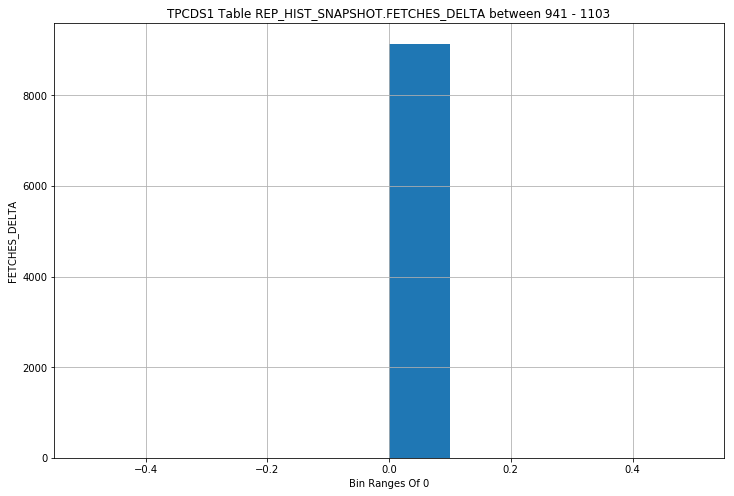

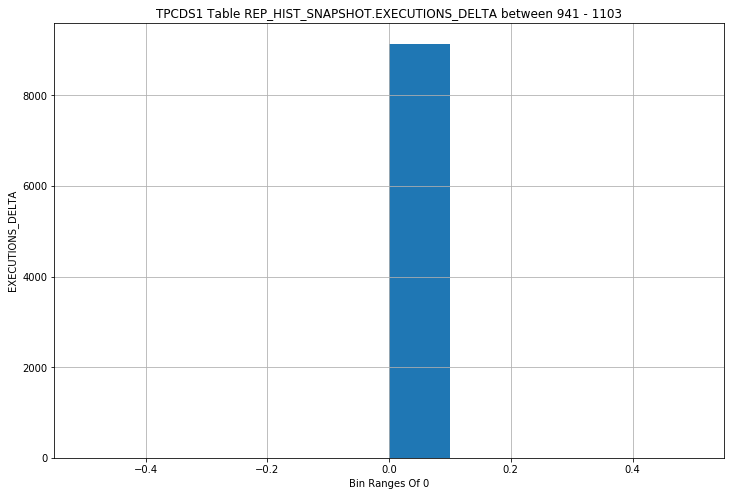

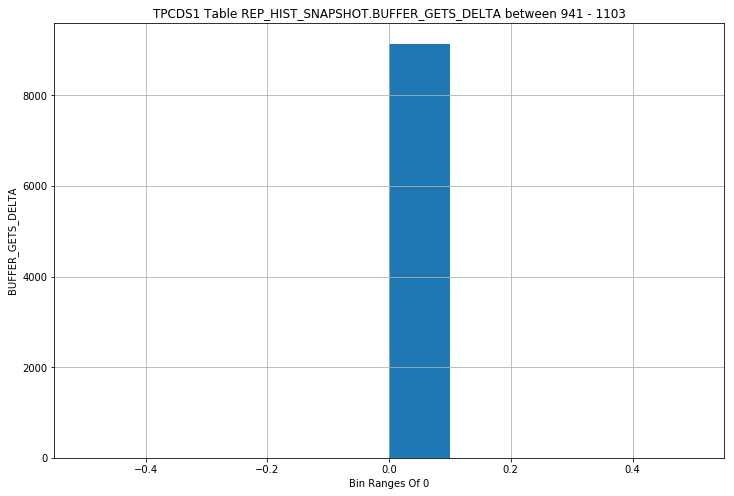

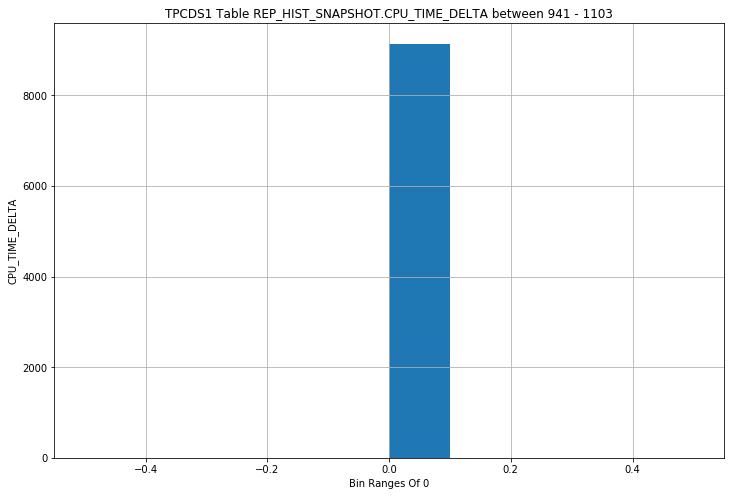

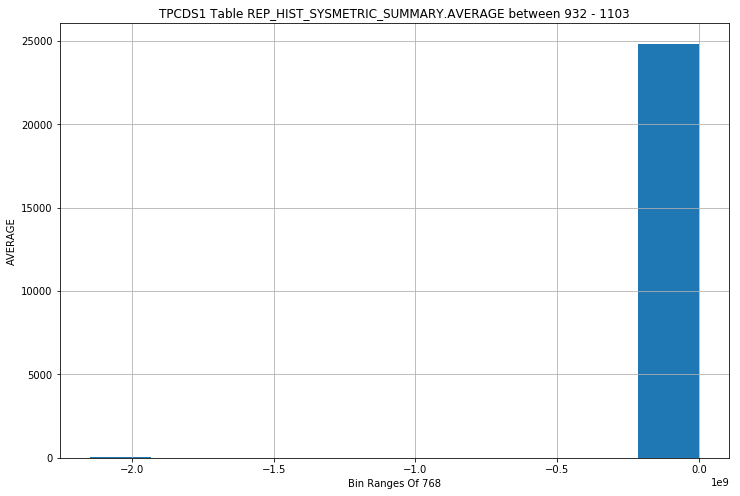

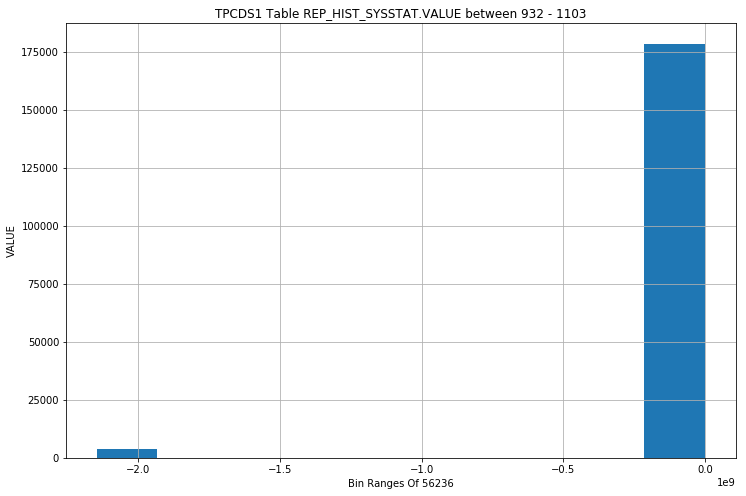

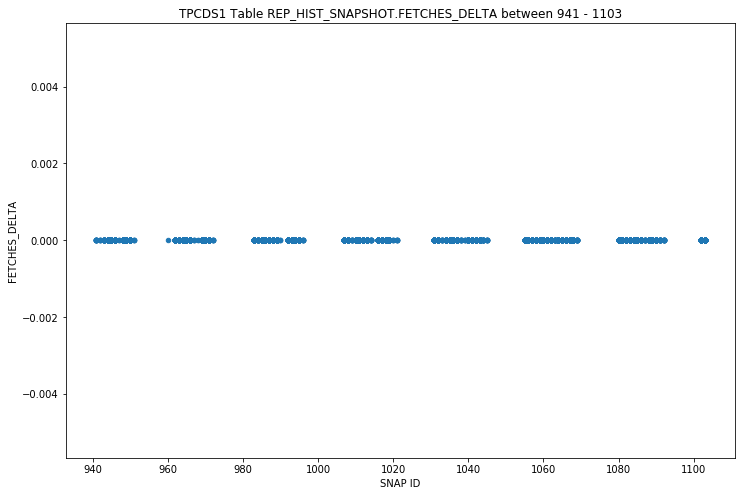

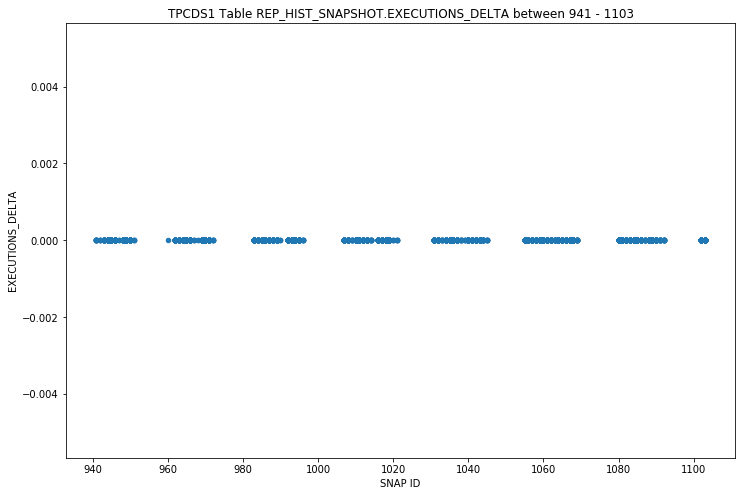

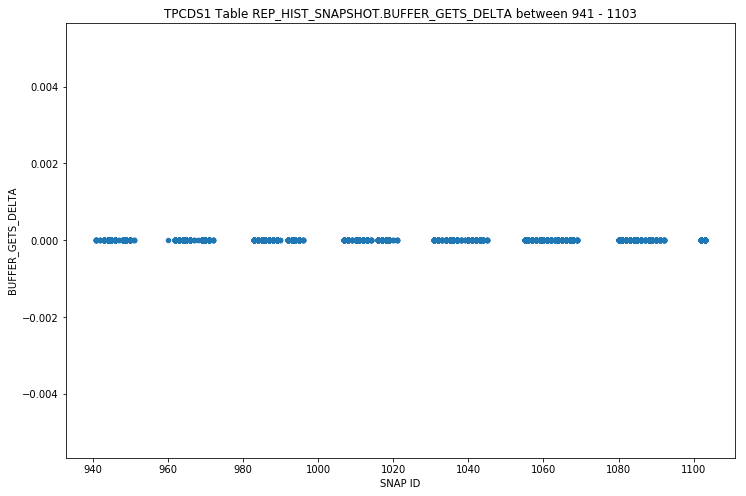

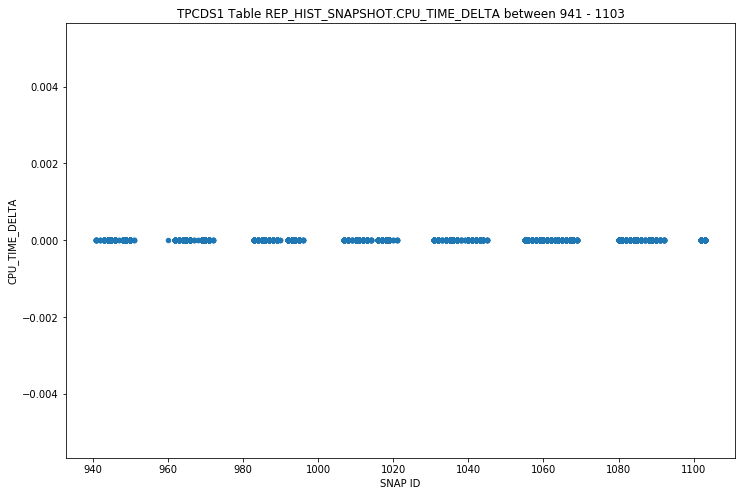

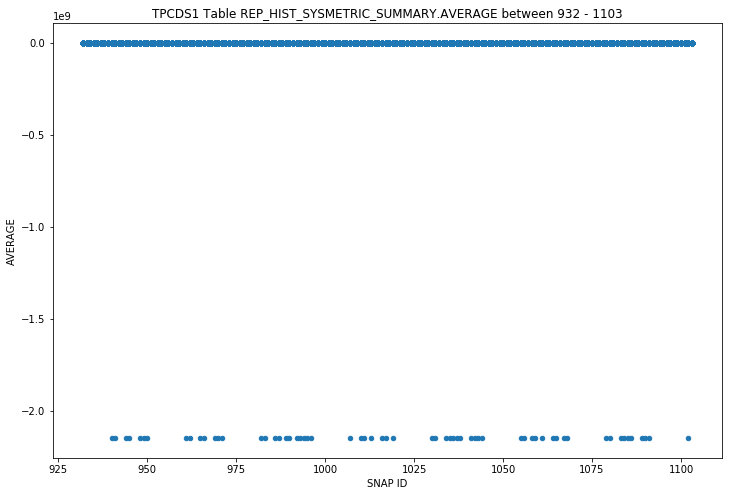

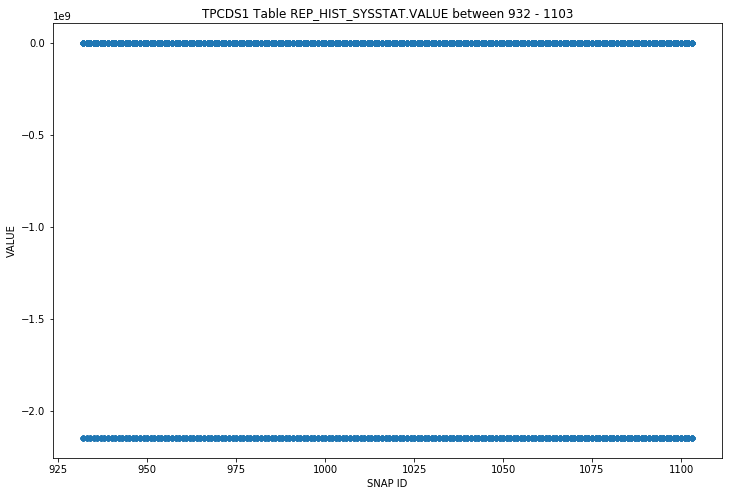

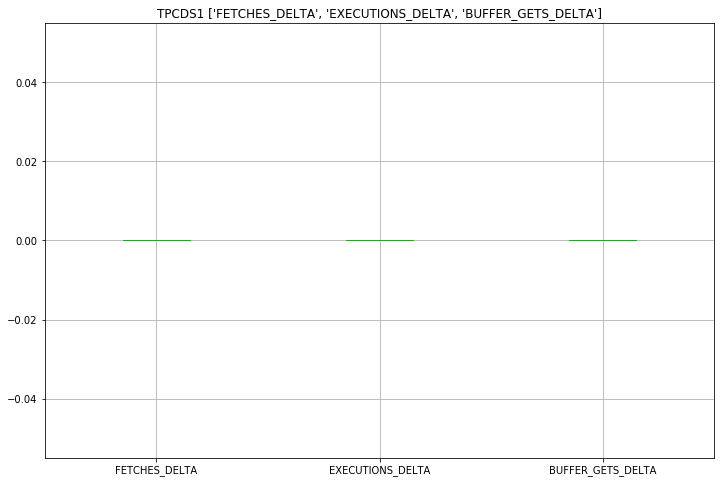

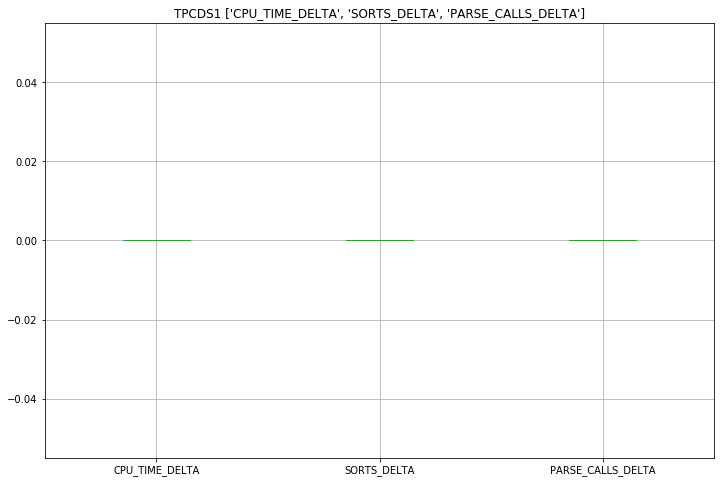

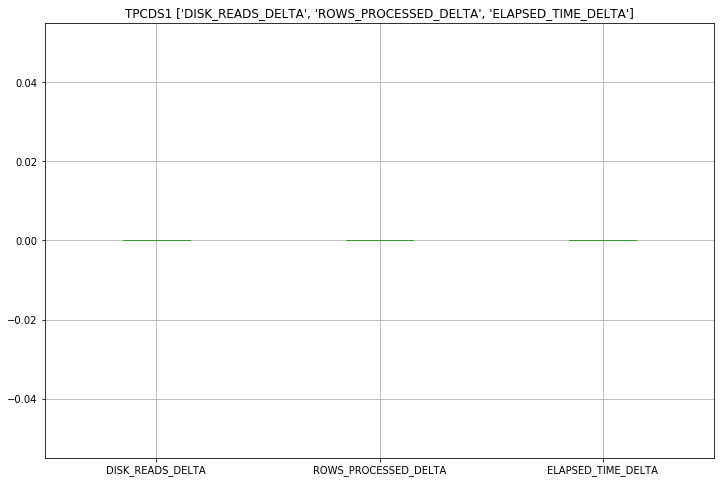

In [20]:
plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='FETCHES_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='EXECUTIONS_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='BUFFER_GETS_DELTA', bin_size=10)
plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column='CPU_TIME_DELTA', bin_size=10)
plot_hist(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column='AVERAGE', bin_size=10)
plot_hist(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds, table='rep_hist_sysstat', feature_column='VALUE', bin_size=10)
#
plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='FETCHES_DELTA')
plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='EXECUTIONS_DELTA')
plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='BUFFER_GETS_DELTA')
plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column='CPU_TIME_DELTA')
plot_scatter(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column='AVERAGE')
plot_scatter(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds,table='rep_hist_sysstat',feature_column='VALUE')
#
#
# Plotting Box Plots
whisker_boxes_per_plot = 3
for i in range(whisker_boxes_per_plot, len(headers), whisker_boxes_per_plot):
    plot_boxplot(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=headers[i-whisker_boxes_per_plot:i])

# Chi2 Test on Features